In [1]:
import os
import re
from os.path import join

import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import OrderedDict

import qnet
from qnet.algebra import *

import QDYN

from src.notebook_plots_v1 import plot_bs_decay, display_hamiltonian, display_eq, show_summary_dicke
from src.single_sided_network_v1 import network_slh
from src.dicke_single_model_v1 import write_dicke_single_model, err_dicke_single
from src.doit_actions_v1 import run_traj_prop

from doit.tools import register_doit_as_IPython_magic

In [2]:
qnet.init_printing()

In [3]:
DOIT_CONFIG = {
    'backend': 'json',
    'dep_file': '.doit_db/2017-06-01_mg_dicke1_QSL_traj1-analysis.json',
}
register_doit_as_IPython_magic()

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Analysis: QSL for Single-Excitation Dicke state

## collect runfolders

In [4]:
DATA_ROOT = './data/dicke1_QSL_1traj'

In [5]:
RX_LEAFFOLDER = re.compile(r'rf_(?P<nodes>\d+)nodes_T(?P<T>[\d_]+)')

In [6]:
def collect_runfolders(data_root):
    runfolders = []
    for dirpath, dirnames, filenames in os.walk(data_root):
        if not dirnames:
            if RX_LEAFFOLDER.match(os.path.split(dirpath)[-1]):
                runfolders.append(dirpath)
            else:
                print(
                    "%s does not match %s" % (dirpath, rx_leaffolder.pattern))
    return runfolders

In [7]:
RUNFOLDERS = collect_runfolders(DATA_ROOT)

In [8]:
N_TRAJS = 20 # for evaluation purposes

## Propagation (doit task)

In [9]:
def task_propagate():
    """Run optimization for every runfolder from params_df"""
    jobs = {}
    for rf in RUNFOLDERS:
        yield {
            'name': str(rf),
            'actions': [
                (run_traj_prop, [rf, ], dict(n_trajs=N_TRAJS))],
            'file_dep': [join(rf, 'pulse1.oct.dat'),],
            'targets': [join(rf, 'state_final.dat.1'),]}

In [10]:
%doit propagate

-- propagate:./data/dicke1_QSL_1traj/rf_3nodes_T1
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T20
-- propagate:./data/dicke1_QSL_1traj/rf_5nodes_T5
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T2
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T50
-- propagate:./data/dicke1_QSL_1traj/rf_5nodes_T3
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T3
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T5
-- propagate:./data/dicke1_QSL_1traj/rf_6nodes_T18
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T4
-- propagate:./data/dicke1_QSL_1traj/rf_6nodes_T15
-- propagate:./data/dicke1_QSL_1traj/rf_5nodes_T6
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T1
-- propagate:./data/dicke1_QSL_1traj/rf_5nodes_T20
.  propagate:./data/dicke1_QSL_1traj/rf_7nodes_T14
.  propagate:./data/dicke1_QSL_1traj/rf_7nodes_T15
-- propagate:./data/dicke1_QSL_1traj/rf_5nodes_T12
-- propagate:./data/dicke1_QSL_1traj/rf_6nodes_T20
-- propagate:./data/dicke1_QSL_1traj/rf_4nodes_T8
-- propagate:./data/dicke1_QSL_1traj/rf_5

## Error Collection

In [11]:
def collect_table(runfolders):
    n_nodes = []
    T = []
    iters = []
    err = []
    for rf in runfolders:
        m = RX_LEAFFOLDER.match(os.path.split(rf)[-1])
        n_nodes.append(int(m.group('nodes')))
        T.append(float(m.group('T').replace('_', '.')))
        pulse = QDYN.pulse.Pulse.read(join(rf, 'pulse1.oct.dat'))
        iters.append(pulse.oct_iter)
        err.append(err_dicke_single(
            rf, final_states_glob='state_final.dat*', rho=False))
    return pd.DataFrame(
        OrderedDict([
            ('n_nodes', n_nodes), ('T', T), ('iters', iters), ('err', err),
            ('rf', runfolders)])
    ).sort_values(['n_nodes', 'T']).reset_index(drop=True)

In [12]:
TABLE = collect_table(RUNFOLDERS)

In [13]:
print(TABLE.to_string())

    n_nodes     T  iters           err                                     rf
0         2   1.0  10000  1.070789e-01   ./data/dicke1_QSL_1traj/rf_2nodes_T1
1         2   2.0  10000  4.414541e-04   ./data/dicke1_QSL_1traj/rf_2nodes_T2
2         2   3.0  10000  3.629770e-05   ./data/dicke1_QSL_1traj/rf_2nodes_T3
3         2   4.0  10000  5.737020e-06   ./data/dicke1_QSL_1traj/rf_2nodes_T4
4         2   5.0   1000  7.740700e-06   ./data/dicke1_QSL_1traj/rf_2nodes_T5
5         2   7.0   1000  4.863587e-07   ./data/dicke1_QSL_1traj/rf_2nodes_T7
6         2  10.0    382  1.330086e-06  ./data/dicke1_QSL_1traj/rf_2nodes_T10
7         2  20.0   1000  1.593274e-07  ./data/dicke1_QSL_1traj/rf_2nodes_T20
8         2  50.0   2000  1.030564e-07  ./data/dicke1_QSL_1traj/rf_2nodes_T50
9         2  70.0   2000  2.080015e-07  ./data/dicke1_QSL_1traj/rf_2nodes_T70
10        3   1.0   4000  1.617824e-01   ./data/dicke1_QSL_1traj/rf_3nodes_T1
11        3   2.0   4000  8.840903e-04   ./data/dicke1_QSL_1traj

In [14]:
def plot_error(table, show=True, floor=1e-5, grid=False):
    from mgplottools.mpl import set_axis
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    n_nodes_values = table['n_nodes'].unique()
    for n_nodes in n_nodes_values:
        if n_nodes == 7:
            continue # XXX not ready yet!
        sub_table = table[table['n_nodes'] == n_nodes]
        ax.plot(sub_table['T'], sub_table['err'].clip(floor, 1),
                'o-', label=str(n_nodes))
    ax.set_xlabel("time (dimensionless units)")
    ax.set_ylabel("error")
    ax.set_yscale('log')
    set_axis(ax, 'x', 0, 10, 1, minor=2)
    if grid:
        ax.grid(which='both')
    ax.legend()
    if show:
        plt.show(fig)
    else:
        return fig

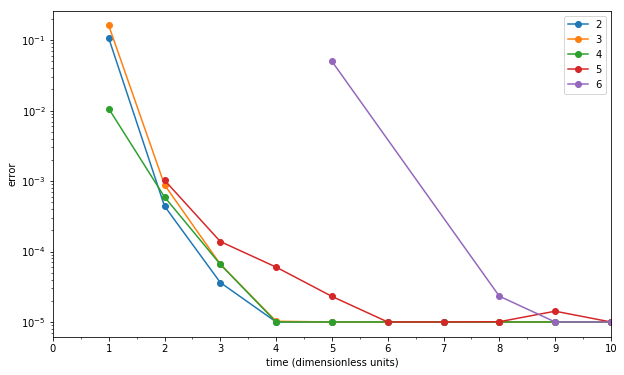

In [18]:
plot_error(TABLE, grid=False, floor=1e-5)

## pulses and dynamics

./data/dicke1_QSL_1traj/rf_2nodes_T1


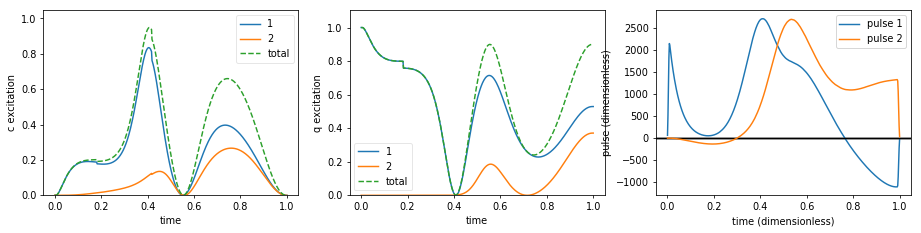

./data/dicke1_QSL_1traj/rf_2nodes_T2


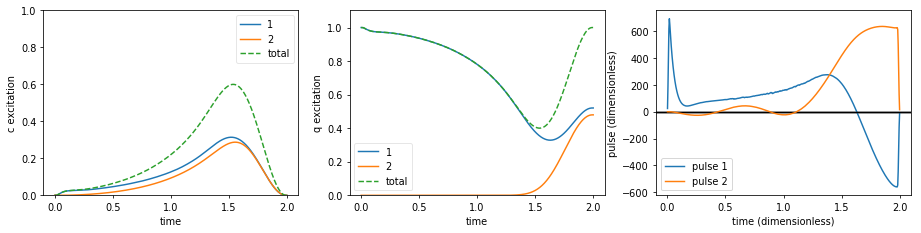

./data/dicke1_QSL_1traj/rf_2nodes_T3


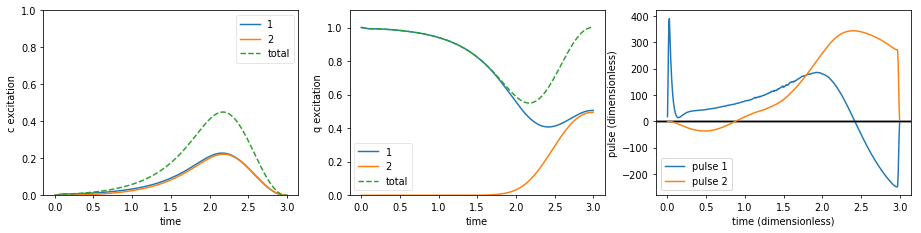

./data/dicke1_QSL_1traj/rf_2nodes_T4


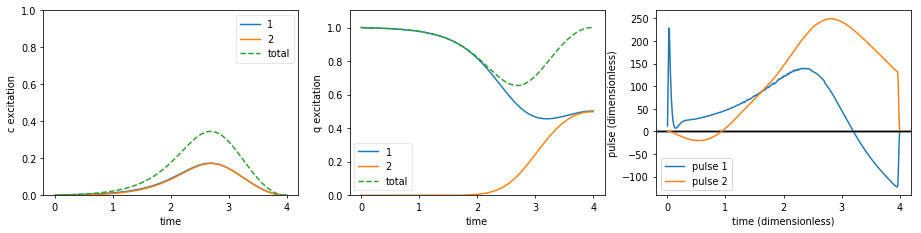

./data/dicke1_QSL_1traj/rf_2nodes_T5


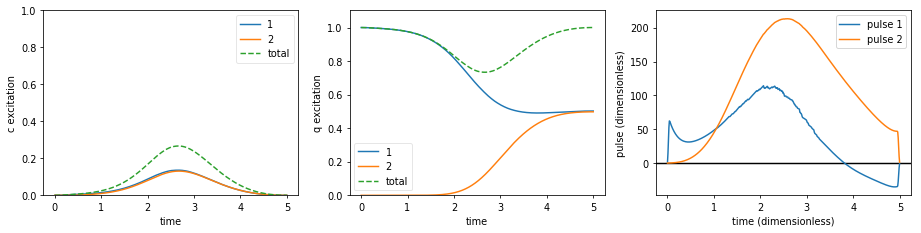

./data/dicke1_QSL_1traj/rf_2nodes_T7


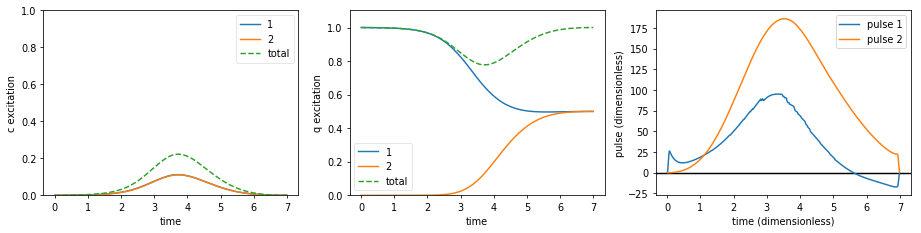

./data/dicke1_QSL_1traj/rf_2nodes_T10


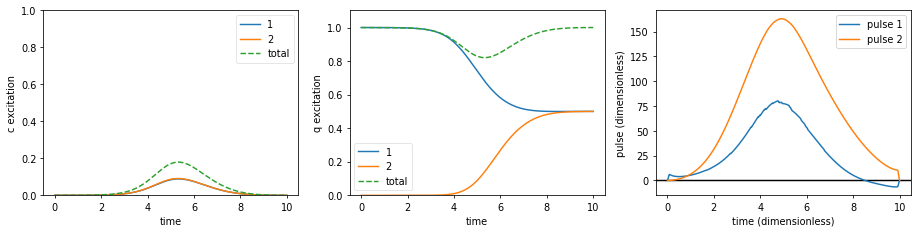

./data/dicke1_QSL_1traj/rf_2nodes_T20


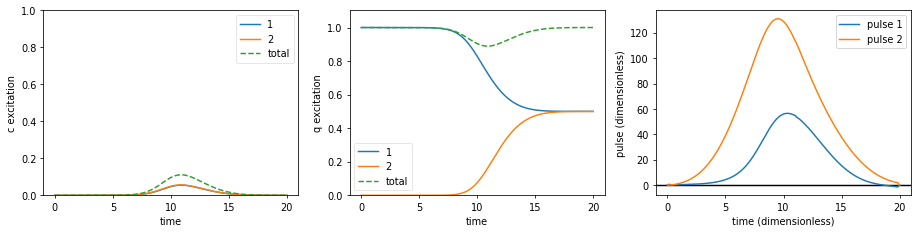

./data/dicke1_QSL_1traj/rf_2nodes_T50


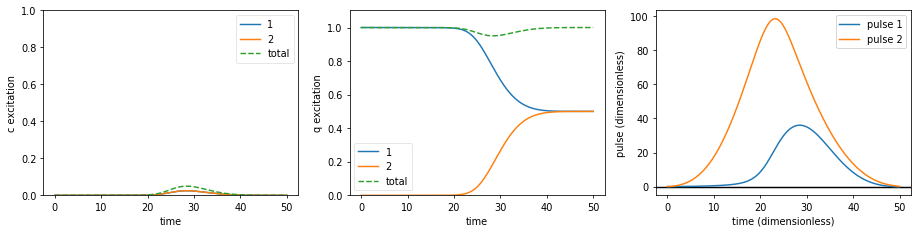

./data/dicke1_QSL_1traj/rf_2nodes_T70


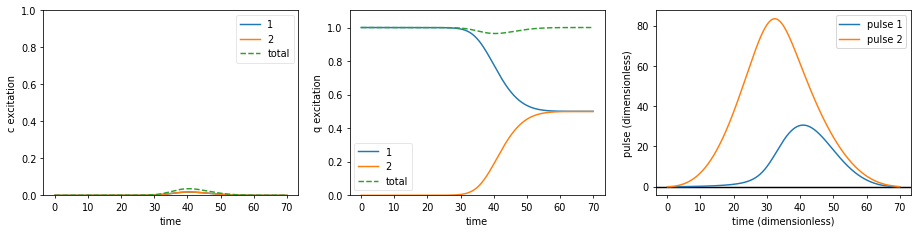

./data/dicke1_QSL_1traj/rf_3nodes_T1


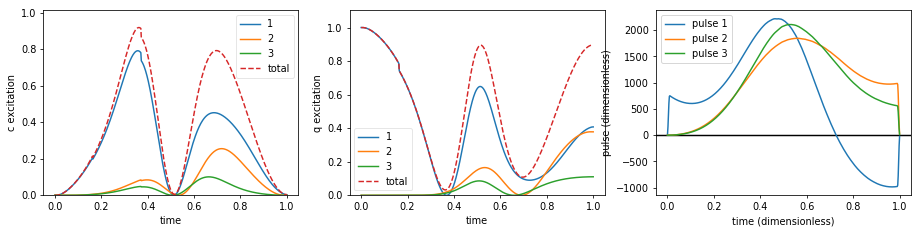

./data/dicke1_QSL_1traj/rf_3nodes_T2


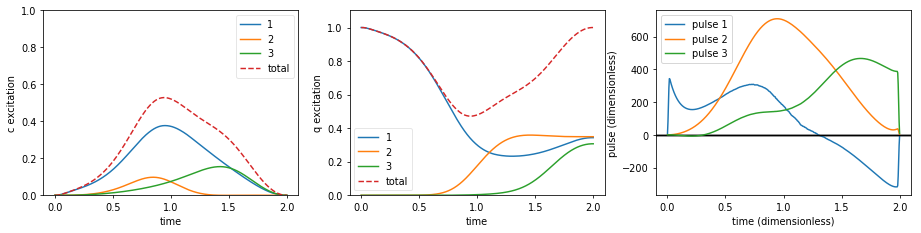

./data/dicke1_QSL_1traj/rf_3nodes_T3


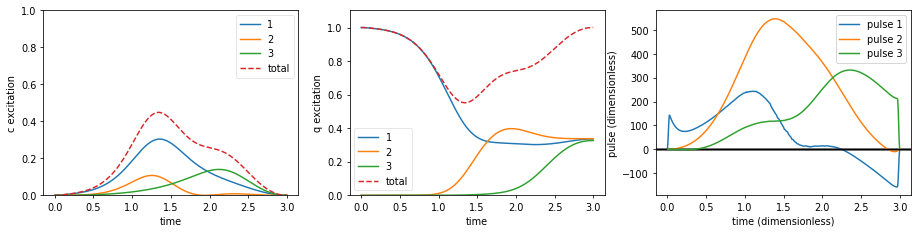

./data/dicke1_QSL_1traj/rf_3nodes_T4


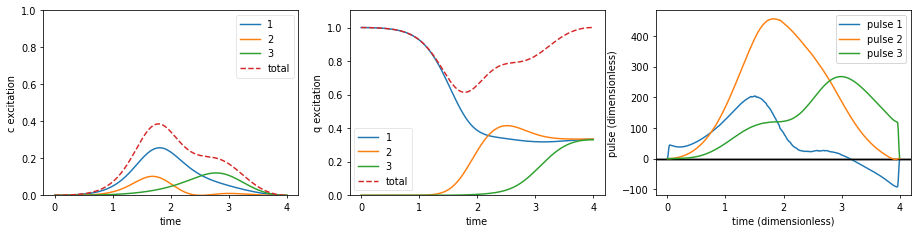

./data/dicke1_QSL_1traj/rf_3nodes_T5


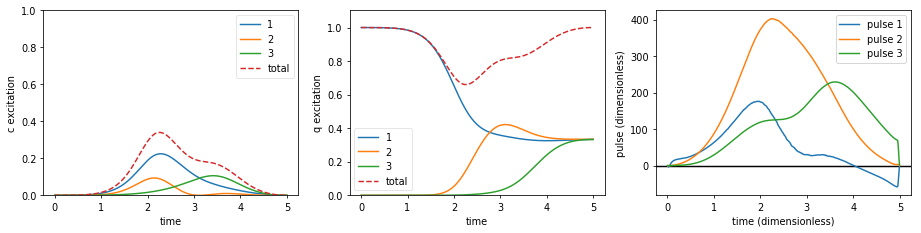

./data/dicke1_QSL_1traj/rf_3nodes_T8


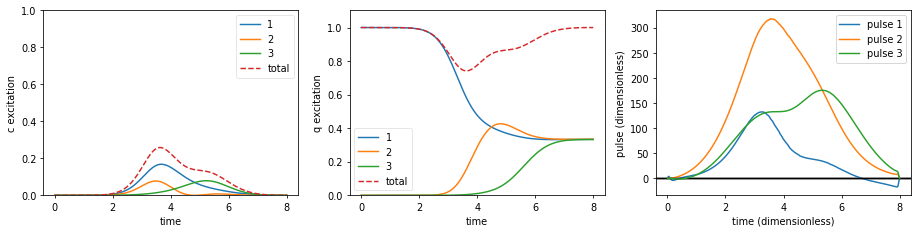

./data/dicke1_QSL_1traj/rf_3nodes_T9


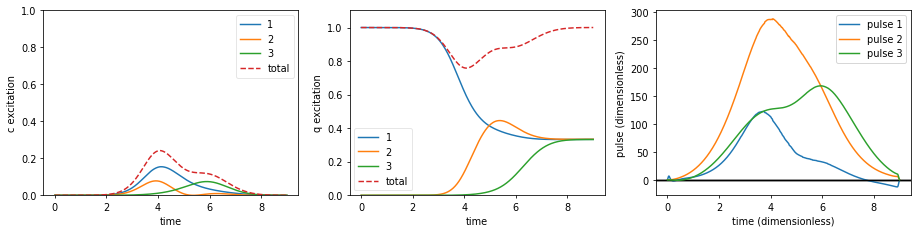

./data/dicke1_QSL_1traj/rf_3nodes_T10


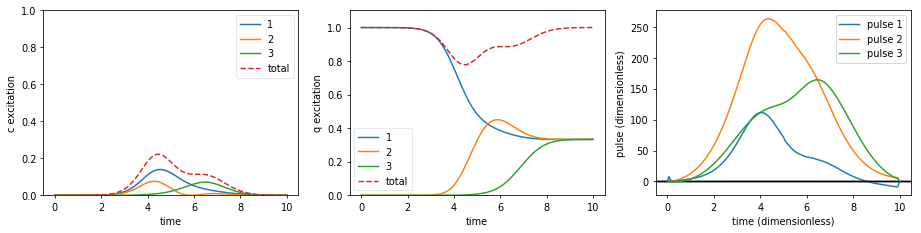

./data/dicke1_QSL_1traj/rf_3nodes_T15


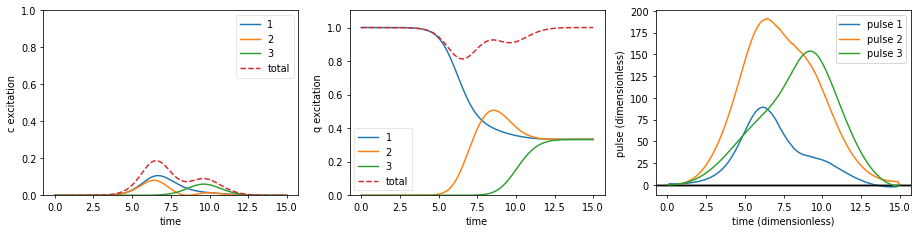

./data/dicke1_QSL_1traj/rf_3nodes_T20


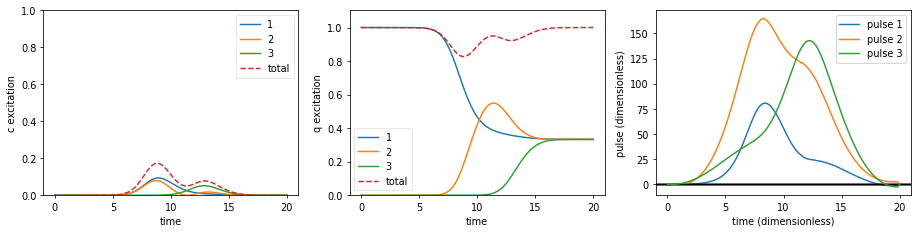

./data/dicke1_QSL_1traj/rf_3nodes_T50


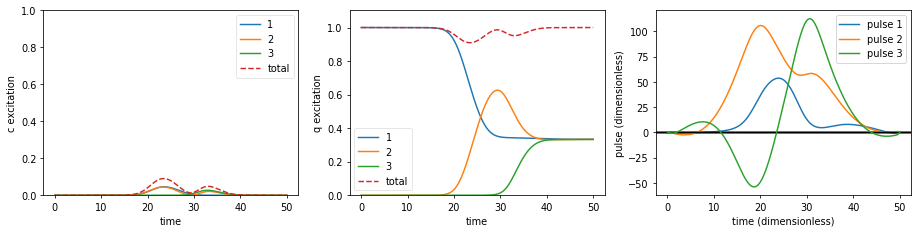

./data/dicke1_QSL_1traj/rf_3nodes_T70


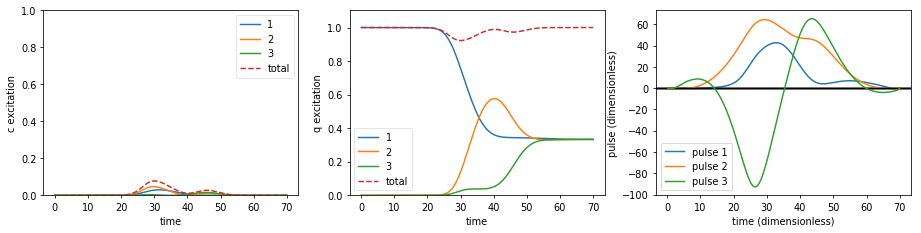

./data/dicke1_QSL_1traj/rf_4nodes_T1


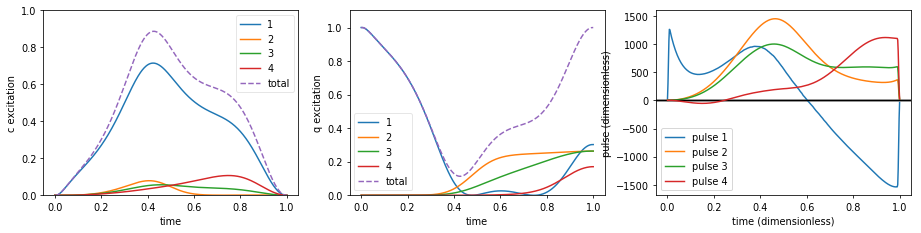

./data/dicke1_QSL_1traj/rf_4nodes_T2


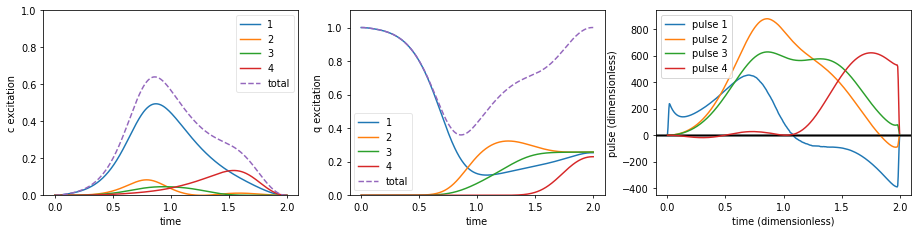

./data/dicke1_QSL_1traj/rf_4nodes_T3


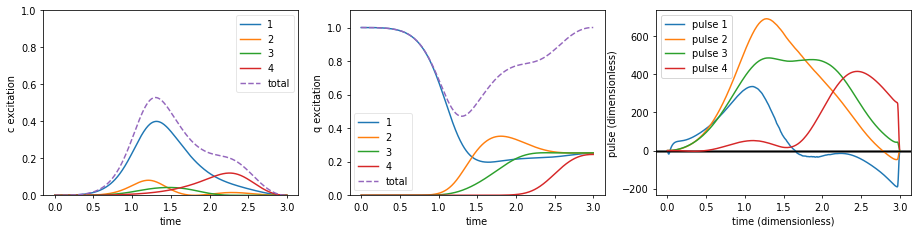

./data/dicke1_QSL_1traj/rf_4nodes_T4


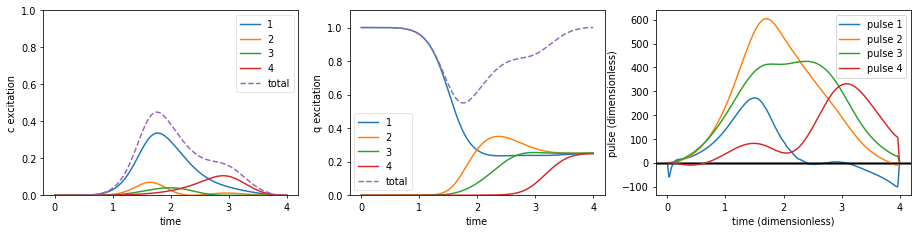

./data/dicke1_QSL_1traj/rf_4nodes_T5


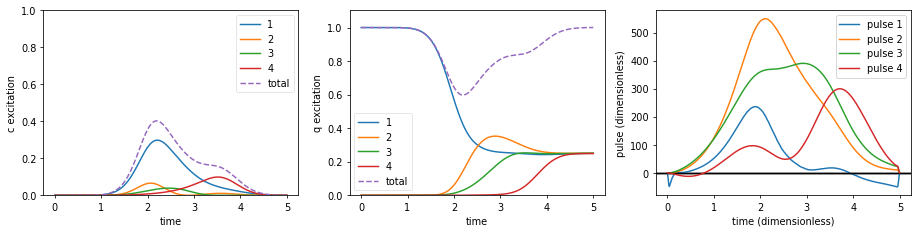

./data/dicke1_QSL_1traj/rf_4nodes_T6


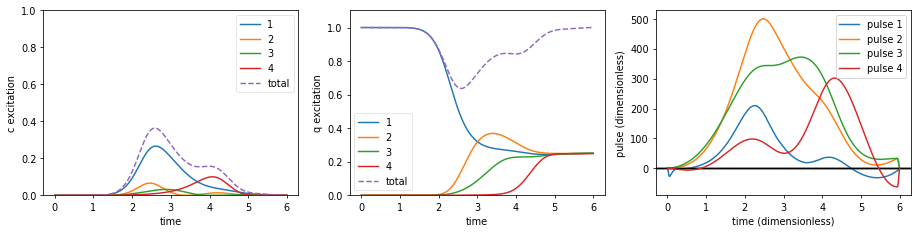

./data/dicke1_QSL_1traj/rf_4nodes_T7


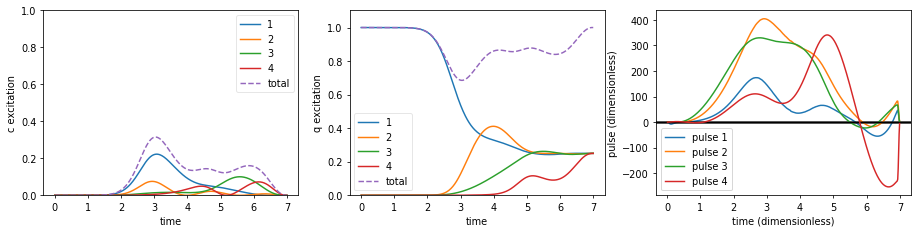

./data/dicke1_QSL_1traj/rf_4nodes_T8


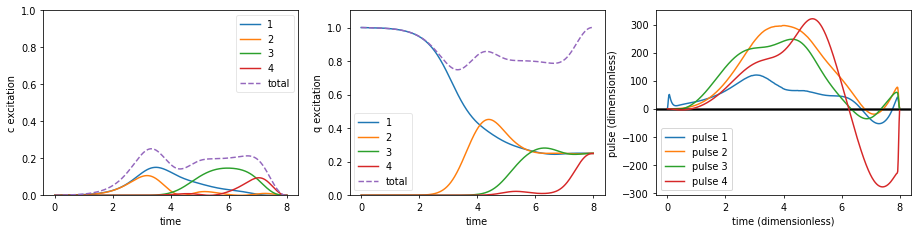

./data/dicke1_QSL_1traj/rf_4nodes_T9


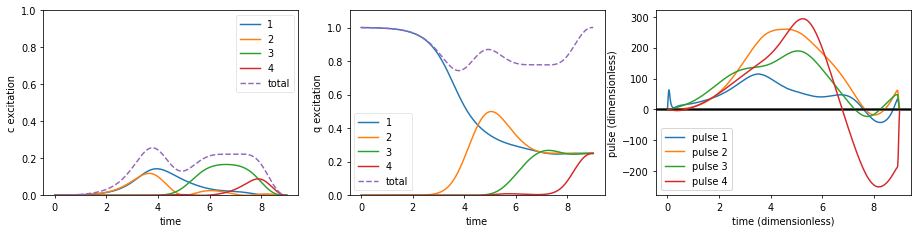

./data/dicke1_QSL_1traj/rf_4nodes_T10


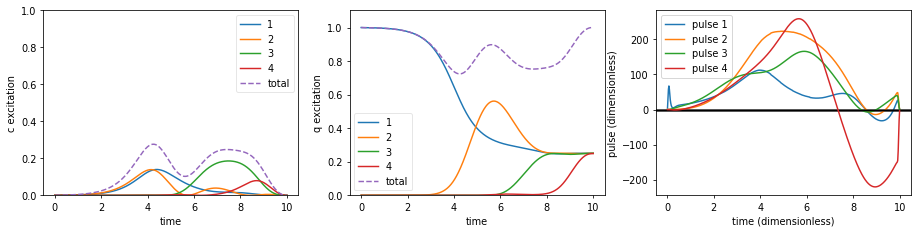

./data/dicke1_QSL_1traj/rf_4nodes_T15


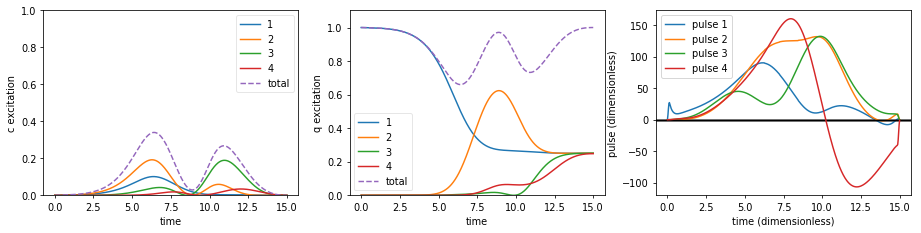

./data/dicke1_QSL_1traj/rf_4nodes_T20


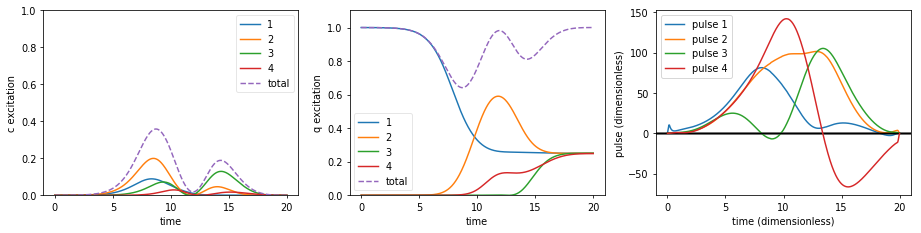

./data/dicke1_QSL_1traj/rf_4nodes_T50


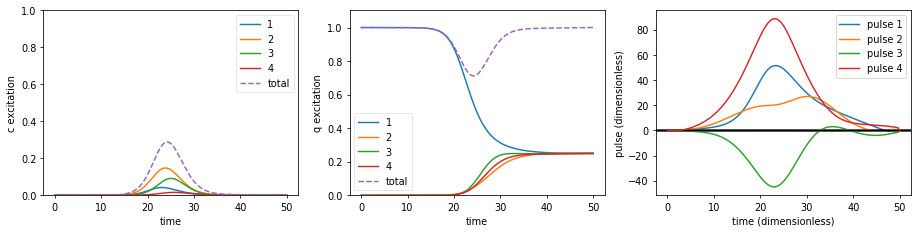

./data/dicke1_QSL_1traj/rf_4nodes_T70


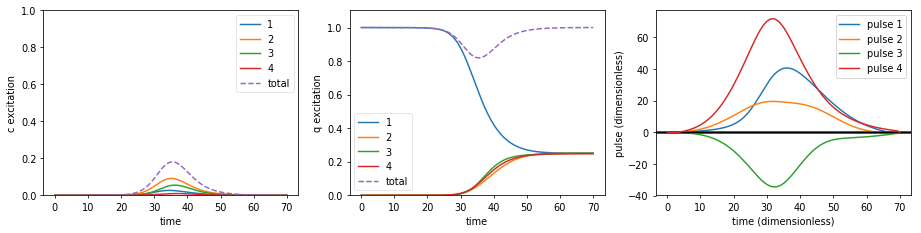

./data/dicke1_QSL_1traj/rf_5nodes_T2


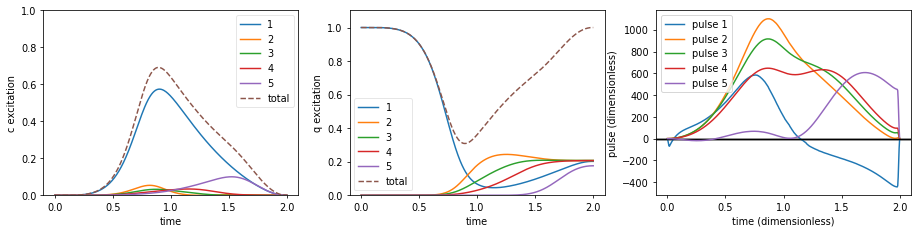

./data/dicke1_QSL_1traj/rf_5nodes_T3


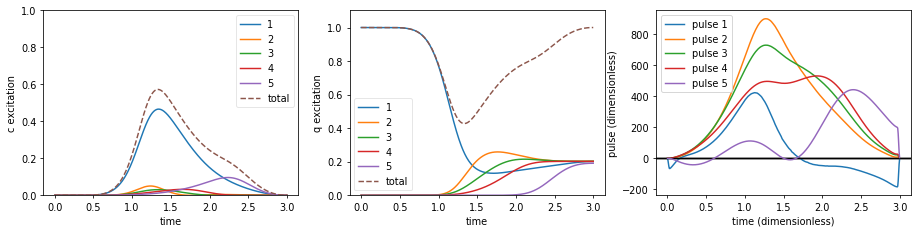

./data/dicke1_QSL_1traj/rf_5nodes_T4


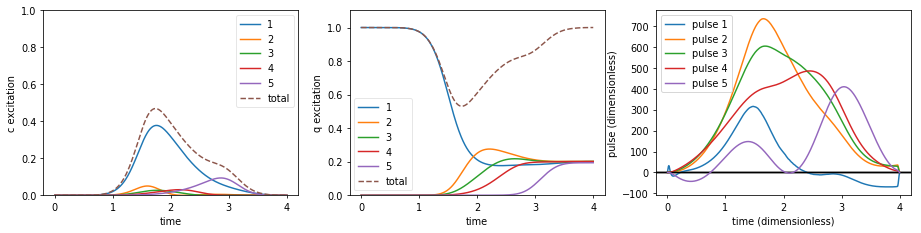

./data/dicke1_QSL_1traj/rf_5nodes_T5


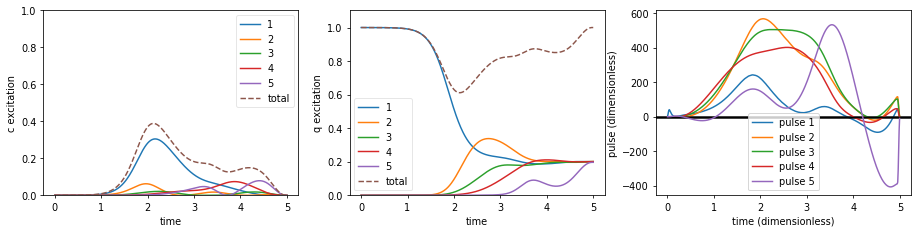

./data/dicke1_QSL_1traj/rf_5nodes_T6


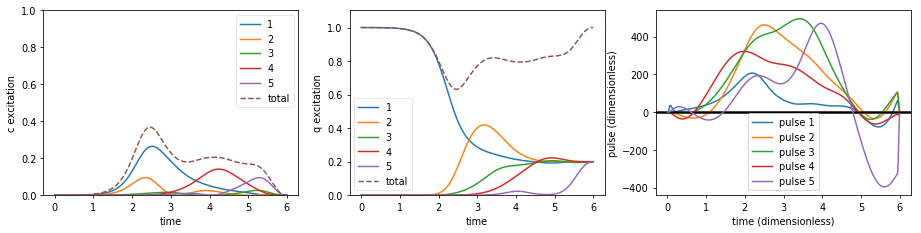

./data/dicke1_QSL_1traj/rf_5nodes_T7


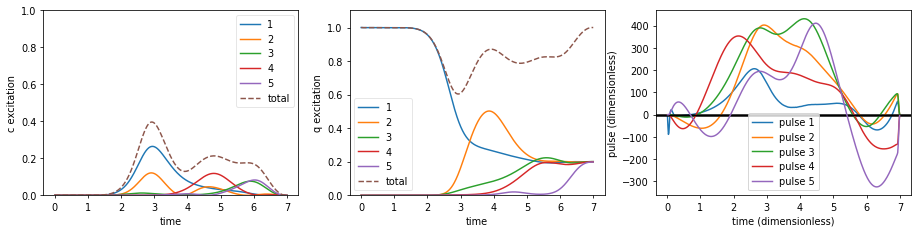

./data/dicke1_QSL_1traj/rf_5nodes_T8


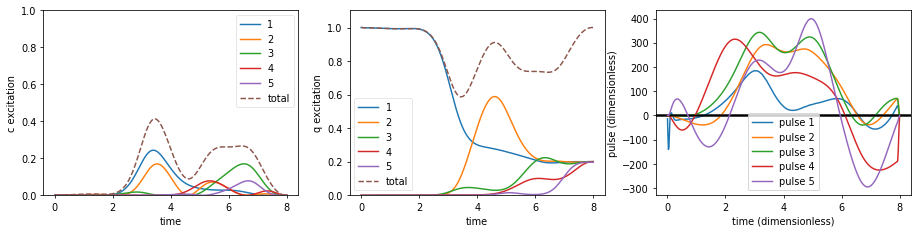

./data/dicke1_QSL_1traj/rf_5nodes_T9


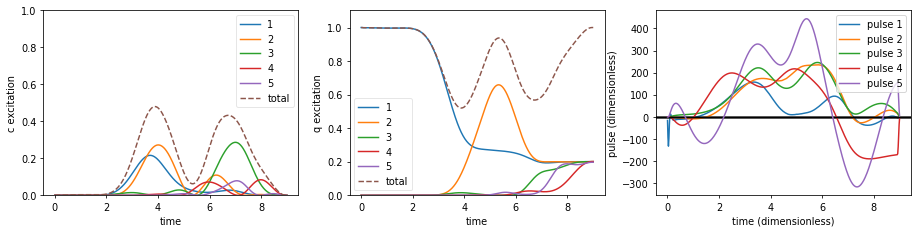

./data/dicke1_QSL_1traj/rf_5nodes_T10


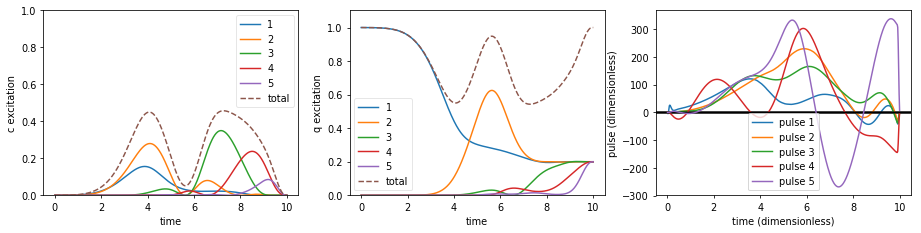

./data/dicke1_QSL_1traj/rf_5nodes_T12


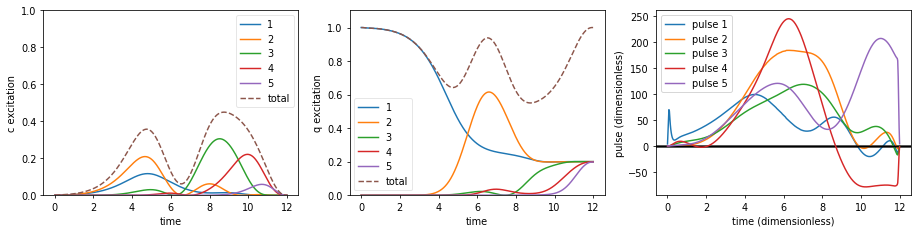

./data/dicke1_QSL_1traj/rf_5nodes_T15


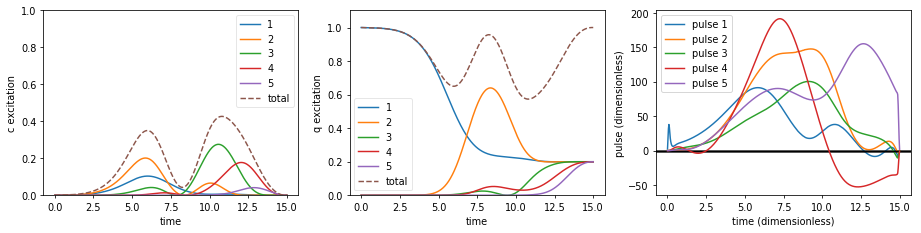

./data/dicke1_QSL_1traj/rf_5nodes_T18


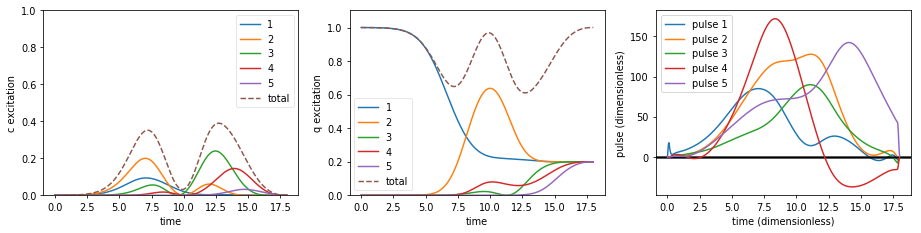

./data/dicke1_QSL_1traj/rf_5nodes_T20


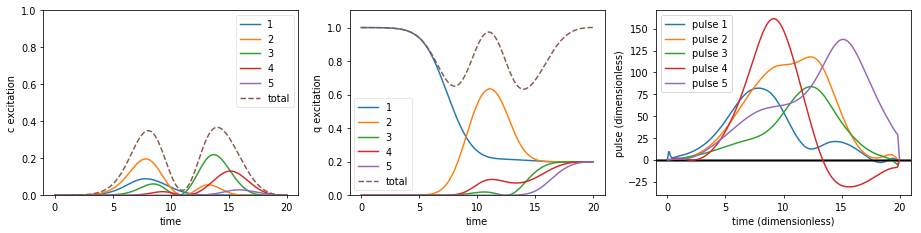

./data/dicke1_QSL_1traj/rf_5nodes_T50


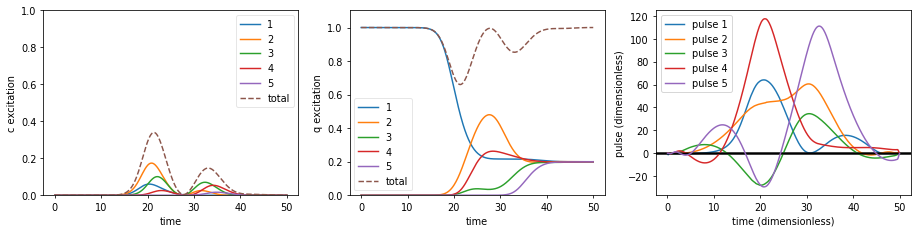

./data/dicke1_QSL_1traj/rf_5nodes_T70


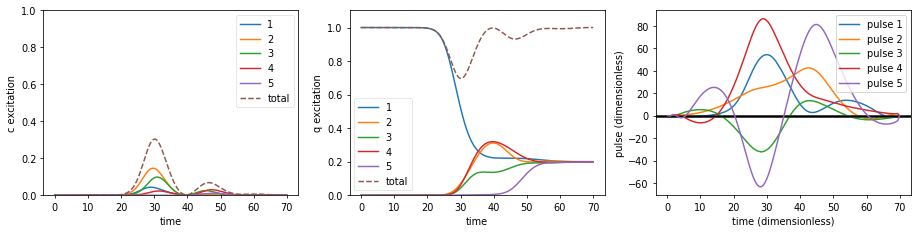

./data/dicke1_QSL_1traj/rf_6nodes_T5


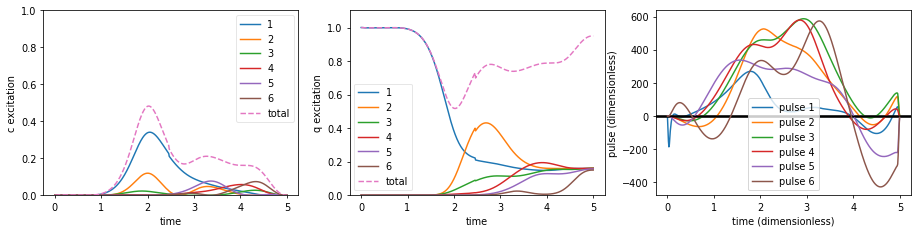

./data/dicke1_QSL_1traj/rf_6nodes_T8


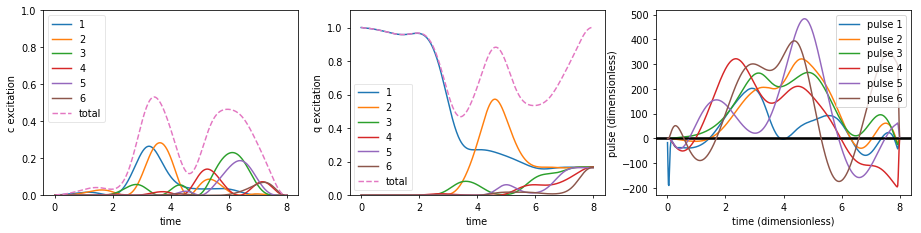

./data/dicke1_QSL_1traj/rf_6nodes_T9


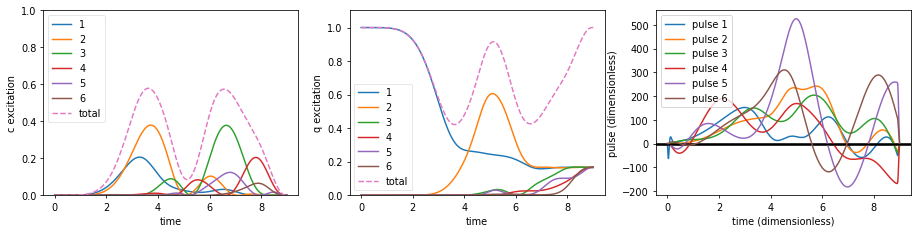

./data/dicke1_QSL_1traj/rf_6nodes_T10


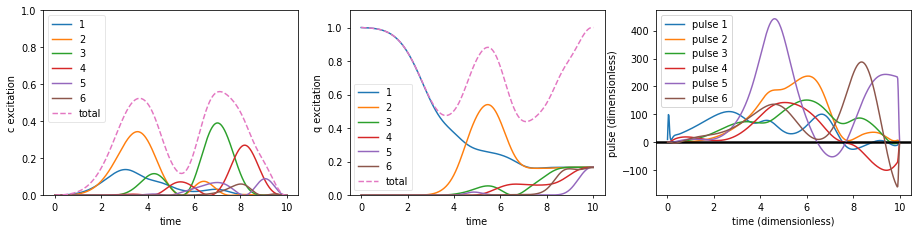

./data/dicke1_QSL_1traj/rf_6nodes_T12


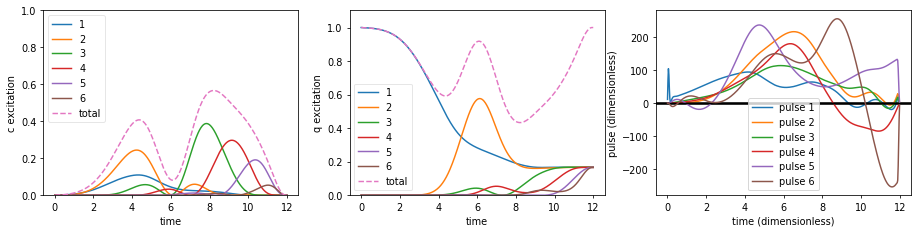

./data/dicke1_QSL_1traj/rf_6nodes_T14


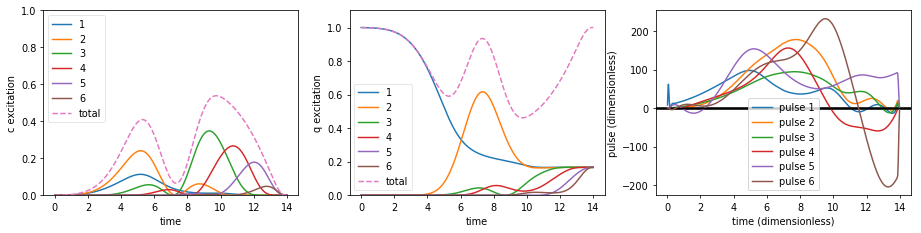

./data/dicke1_QSL_1traj/rf_6nodes_T15


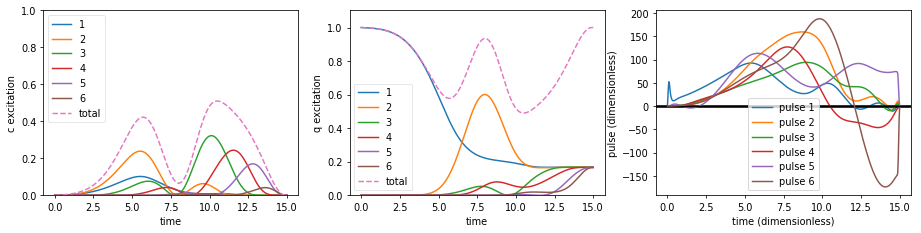

./data/dicke1_QSL_1traj/rf_6nodes_T18


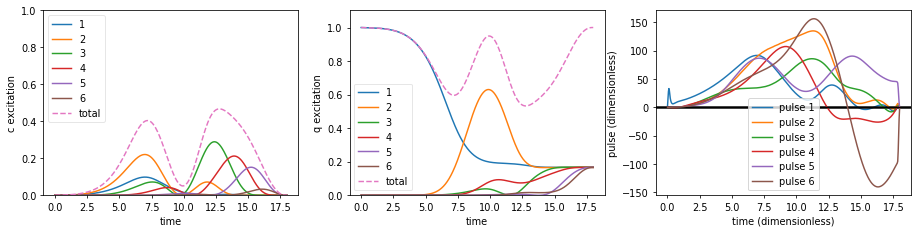

./data/dicke1_QSL_1traj/rf_6nodes_T20


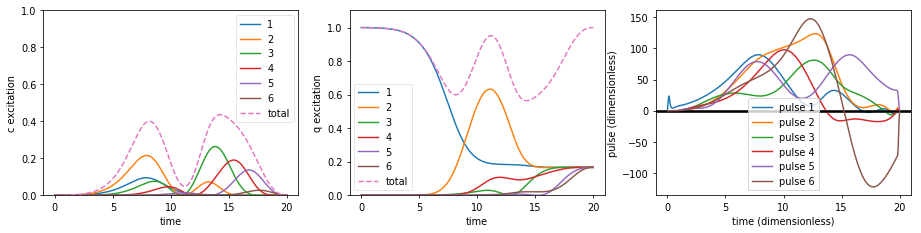

./data/dicke1_QSL_1traj/rf_6nodes_T50


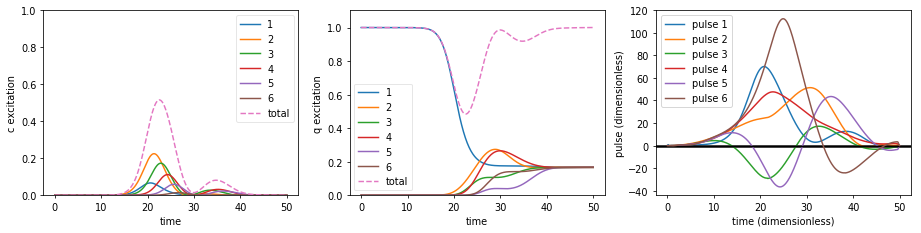

./data/dicke1_QSL_1traj/rf_6nodes_T70


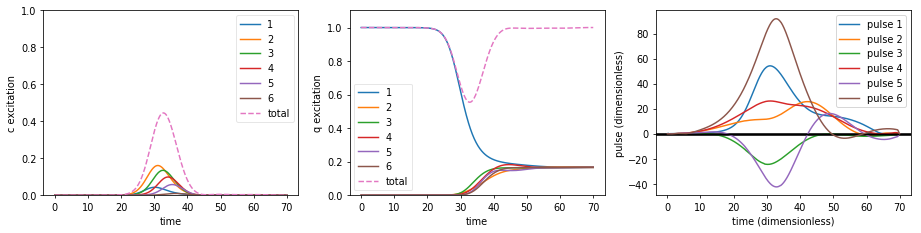

./data/dicke1_QSL_1traj/rf_7nodes_T5


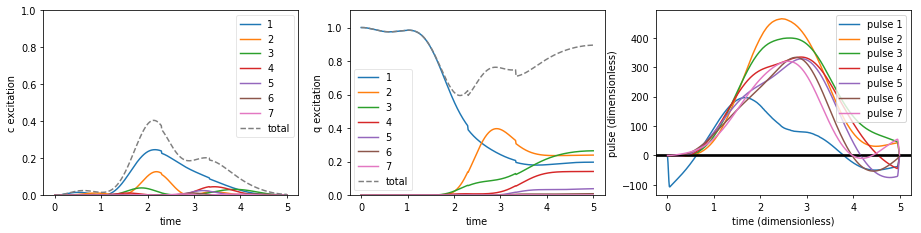

./data/dicke1_QSL_1traj/rf_7nodes_T8


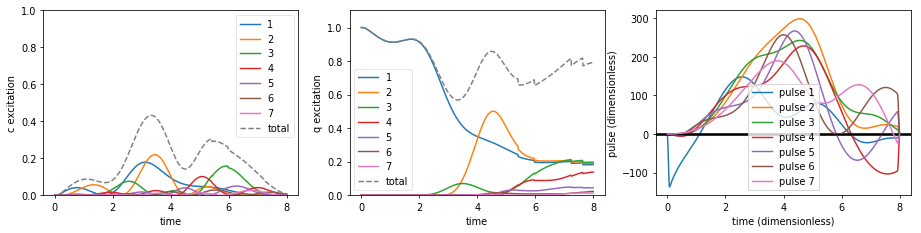

./data/dicke1_QSL_1traj/rf_7nodes_T9


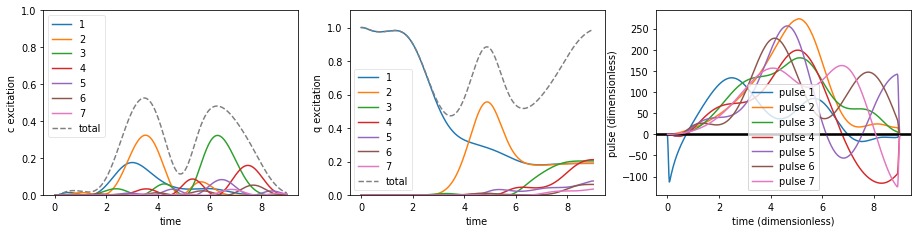

./data/dicke1_QSL_1traj/rf_7nodes_T10


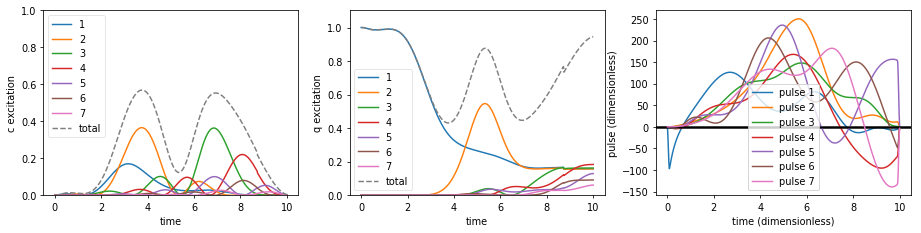

./data/dicke1_QSL_1traj/rf_7nodes_T12


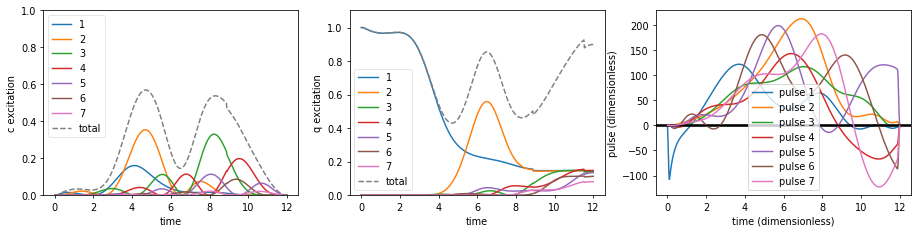

./data/dicke1_QSL_1traj/rf_7nodes_T14


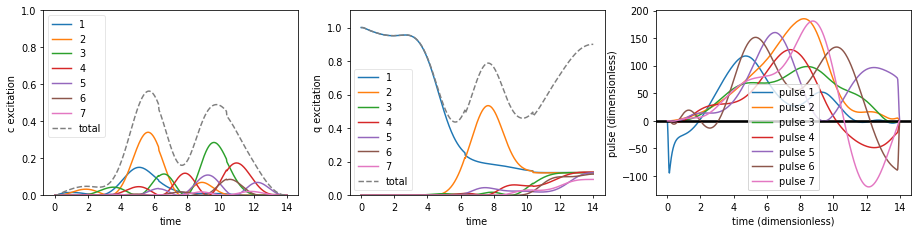

./data/dicke1_QSL_1traj/rf_7nodes_T15


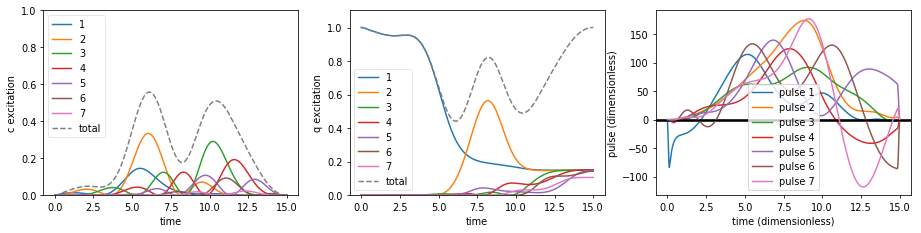

In [16]:
for rf in TABLE['rf']:
    print(rf)
    show_summary_dicke(rf)